# MOM Elastic_Net

In [39]:
import sys,os

In [40]:
sys.path.append(os.path.abspath('/Users/charleslaroche/Documents/GitHub/MOM-algorithms/procedure'))

In [41]:
import random as rd
import numpy as np
import numpy.random as alea
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from procedure_MOM import * 
from random_data import *

plt.style.use('seaborn-darkgrid')
%matplotlib notebook

In [1]:
class MOM_ElasticNet():
    
    def __init__(self , rho=1., Lambda= 0 , K=1, random_state=True, max_iter=1000, tol=10e-5):
        self.rho = rho
        self.Lambda = Lambda
        self.K = K
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol
        self.w = None
        self.intercept = None
        self.Loss = None
    
    def fit(self, X, y, bias = True , coef_init = None):
        
        self.hist = []
        n_samples, n_features = X.shape
        if bias : 
            
            X = np.concatenate((np.ones(n_samples) , X))
        
        if coef_init == None:
            w = np.ones((n_features))
            
        elif w.shape[0] != n_features:
            raise Error('Shape of coef array does not match number of features')
            
        else:
            w = coef_init

        block_size = n_samples // self.K
            
        X_corrected = (X - np.mean(X,axis=0)) / np.std(X,axis=0)
        Residuals = y - X_corrected @ w
        
        Loss = np.empty(0)
        var_w = self.tol + 1
        n_iter = 0

        while n_iter < self.max_iter and var_w > self.tol:    
            
            median_indexes = MOM(np.square(Residuals) , self.K)[1]
            self.hist += median_indexes.tolist()
        
            X_mean = np.mean(X[median_indexes],axis=0)
            X_std = np.std(X[median_indexes],axis=0)
            X_corrected = (X - X_mean)/X_std
            Residuals = y - X_corrected @ w

            X_train = X_corrected[median_indexes]
            R_train = Residuals[median_indexes]
            Loss = np.append(Loss, 0.5 * np.mean(np.square(R_train)))
        
            var_w = 0
        
            for j in range(n_features):
                w_j = w[j]
                R_train = R_train + w_j * X_train[:,j]
                w[j] = scalar_soft_thresholding(self.rho * self.Lambda , np.mean(R_train * X_train[:,j]))/(1 + self.Lambda * (1 - self.rho))
                var_w += (w_j - w[j])**2
        
            n_iter += 1
        
        y_mean = np.mean(y[median_indexes])
        self.Loss = Loss
        self.w = w / X_std
        self.intercept = y_mean - np.sum(self.w * X_mean)
    
    
    def predict(self, X):
        return(self.intercept + np.dot(X,self.w))
    
    
    def score(self , X , y):
        y_predict = self.intercept + X @ self.w
        y_mean = np.mean(y)
        return(1-(np.sum(np.square(y-y_predict)))/(np.sum(np.square(y-y_mean))))


In [2]:
def graph_supp_detection(t_0,B) :
    
    p = np.shape(t_0)[0]
    
    plt.figure(figsize  =  (15, 4))
    plt.stem(t_0, markerfmt = 'ro', label = 'true')
    plt.title('t_0')
    plt.figure(figsize  =  (15, 4))
    plt.stem(B, markerfmt = 'ro', label = 'true')
    plt.title('Approximation of t_0')

### Test de l'algorithme de descente de coordonnées / Sans Outliers

<IPython.core.display.Javascript object>


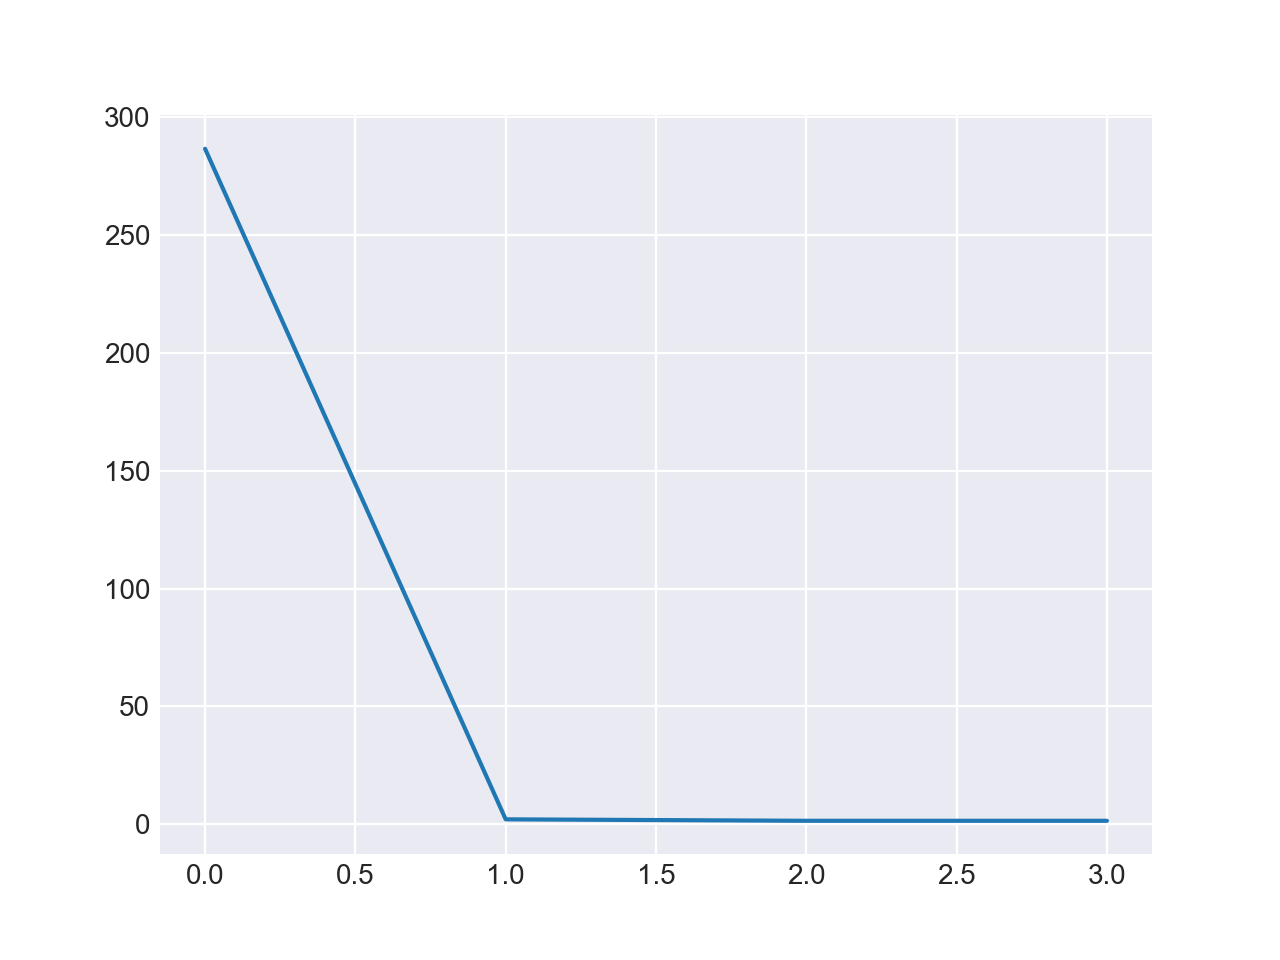

0.9942331656155524

In [56]:
n_samples = 10000
t = create_t_0(50 , 10)
sigma = 1

Y , X = data1(n_samples , t , sigma)

reg = MOM_ElasticNet()
reg.fit(X,Y.flatten())

plt.plot(reg.Loss)
plt.show()

reg.score(X,Y)

<IPython.core.display.Javascript object>


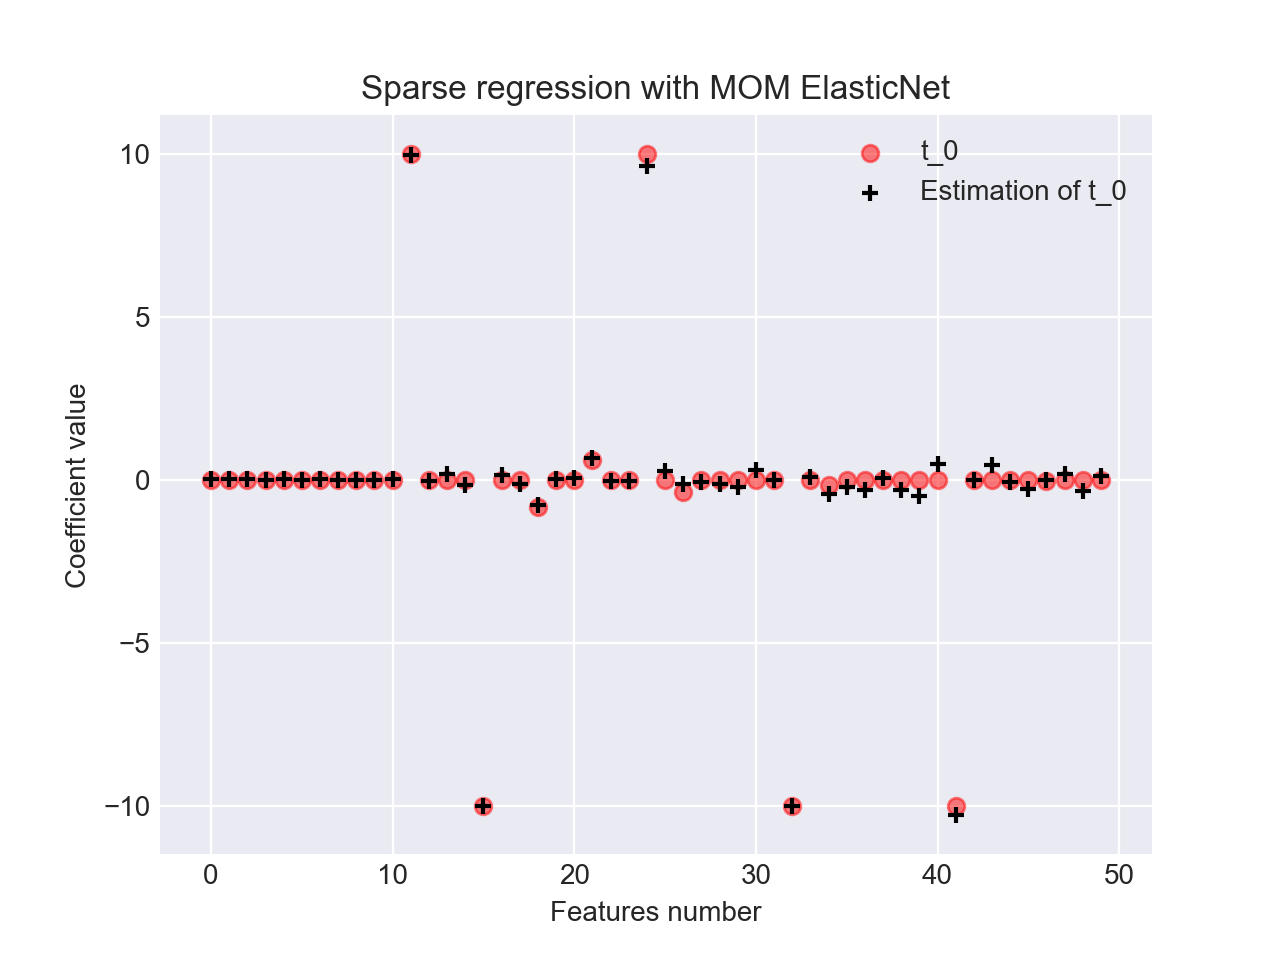

Text(0.5, 1.0, 'Sparse regression with MOM ElasticNet')

In [57]:
plt.scatter(np.arange(50) , t , color = 'red' , alpha = 0.5 , label = "t_0")
plt.scatter(np.arange(50) , reg.w , color = "black" , marker = "+" , label = "Estimation of t_0")
plt.legend()
plt.xlabel("Features number")
plt.ylabel("Coefficient value")
plt.title('Sparse regression with MOM ElasticNet')

### Test de l'algorithme de descente de coordonnées / Avec Outliers

(20000,) (100,)


<IPython.core.display.Javascript object>


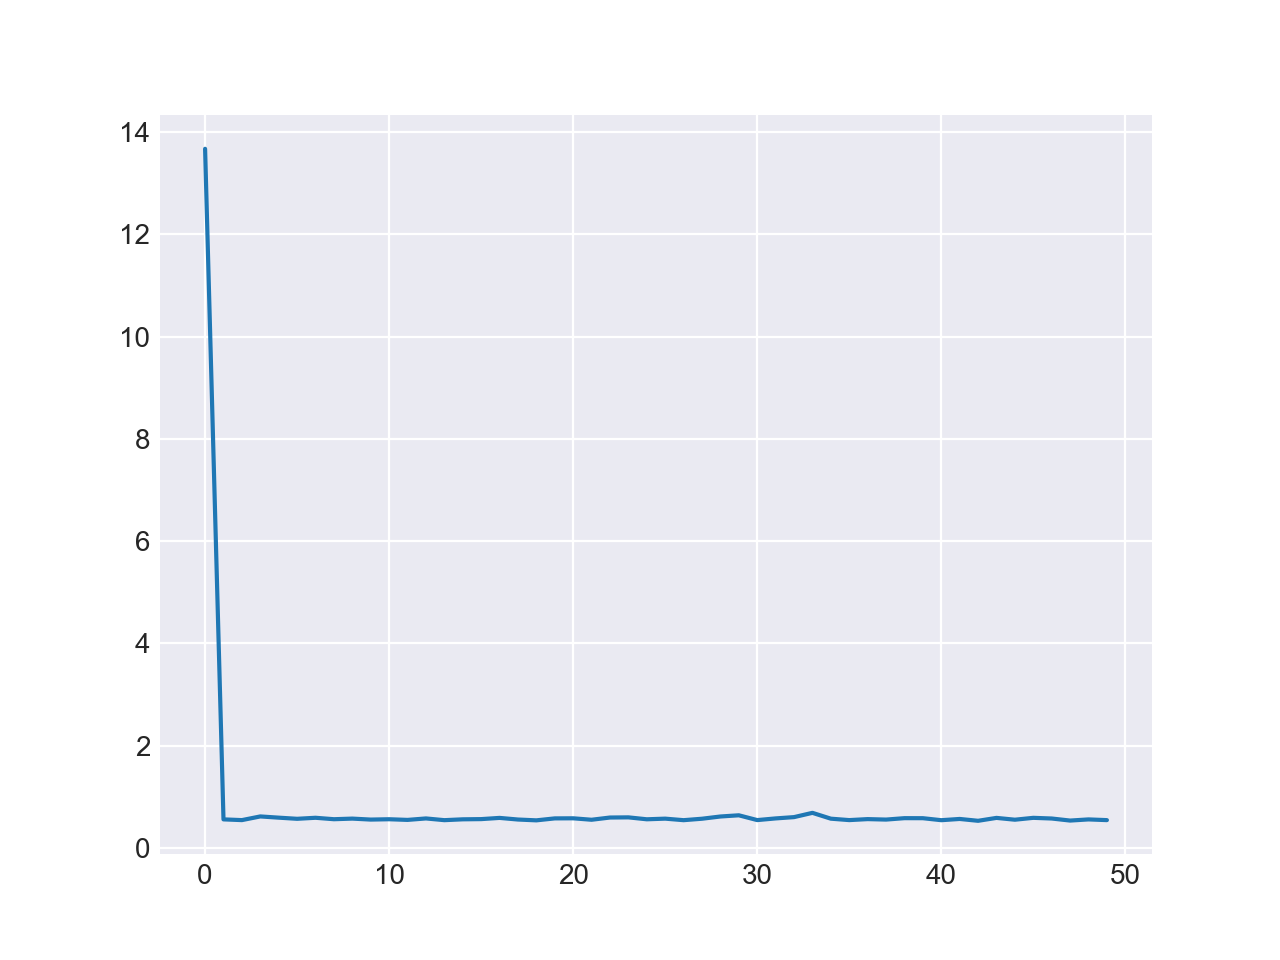

In [58]:
n_samples = 20000
cov1 = np.identity((3))
cov2 = np.array([2.5, 1., -0.8, 1., 0.5, 0.0, -0.8, 0.0, 7.6]).reshape((3,3))
t = np.array([2.,1.,-4.])
sigma = 1

Y1,X1 = data1(n_samples , t , sigma)

n_heavy_tail = 100
Y2,X2 = data3(n_heavy_tail,t)

n_outliers1 = 100
Y3,X3 = data2(n_outliers1, 3, type_outliers = 1)

n_outliers2 = 5
Y4,X4 = data2(n_outliers2, 3, type_outliers = 2)

print(Y1.shape,Y2.shape)
Y5,X5 = data_merge(Y1,X1,Y2,X2)

Y6,X6 = data_merge(Y5,X5,Y3,X3)

Y,X = data_merge(Y6,X6,Y4,X4)

reg = MOM_ElasticNet(rho = 0.2, Lambda = 0.0, K = 15, random_state = True, max_iter = 50, tol = 10**-4)
reg.fit(X,Y)

plt.plot(reg.Loss)
plt.show()

<IPython.core.display.Javascript object>


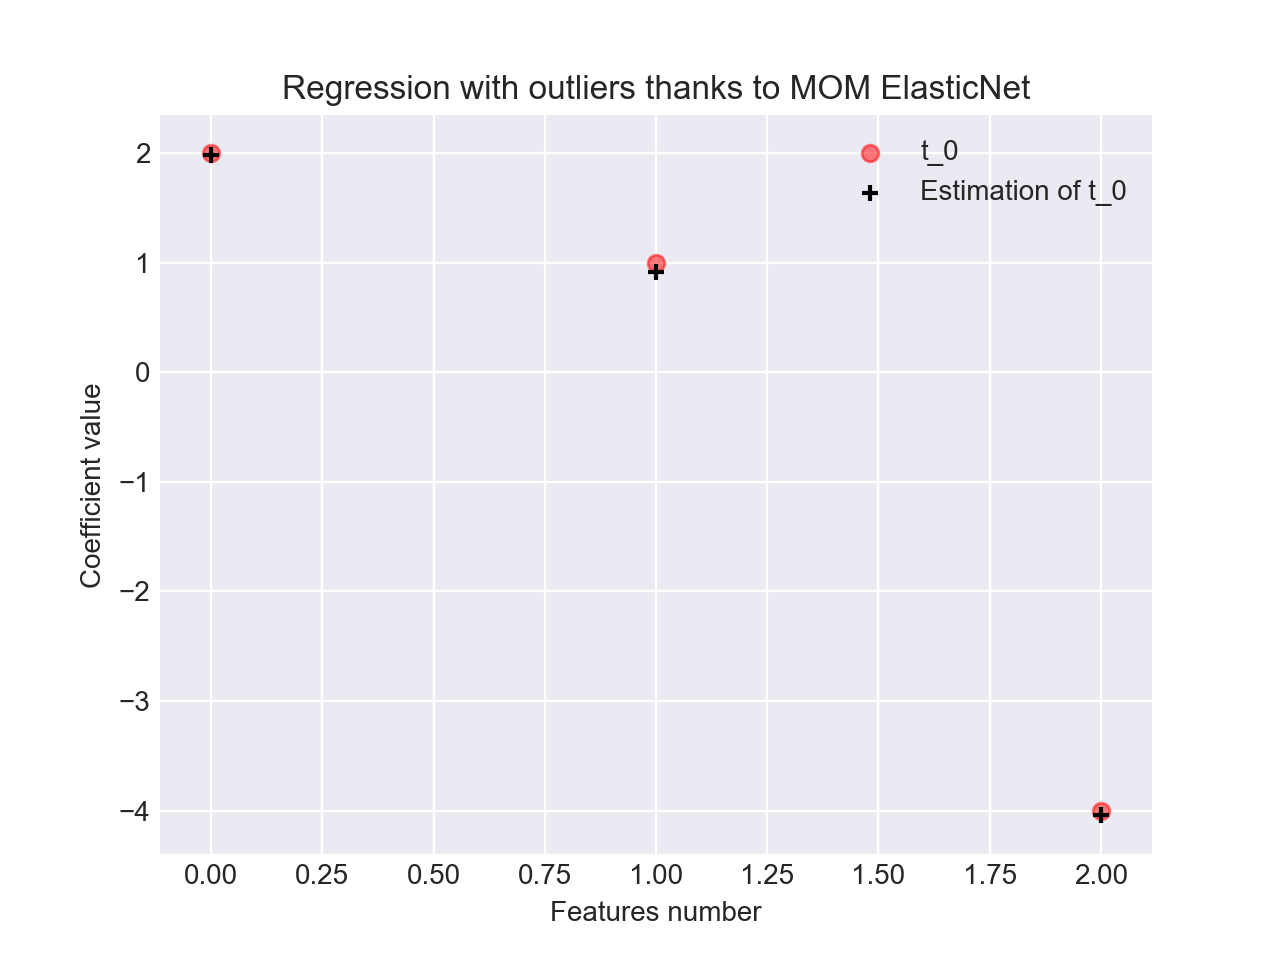

Text(0.5, 1.0, 'Regression with outliers thanks to MOM ElasticNet')

In [59]:
plt.scatter(np.arange(3) , t , color = 'red' , alpha = 0.5 , label = "t_0")
plt.scatter(np.arange(3) , reg.w , color = "black" , marker = "+" , label = 'Estimation of t_0')
plt.legend()
plt.xlabel("Features number")
plt.ylabel("Coefficient value")
plt.title('Regression with outliers thanks to MOM ElasticNet')

On remarque dans la cellule ci-dessus qu'il est nécessaire que le nombre de blocks soient strictement plus grand que deux fois le nombre d'outliers : en effet si cette hypothèse n'est pas vérifiée et dans le cas ou les outliers seraient répartis dans des blocks différents, le block médian peut contenir un outlier et fausser l'apprentissage 

### Test de l'algorithme de descente de coordonnées / Sparsity

<IPython.core.display.Javascript object>


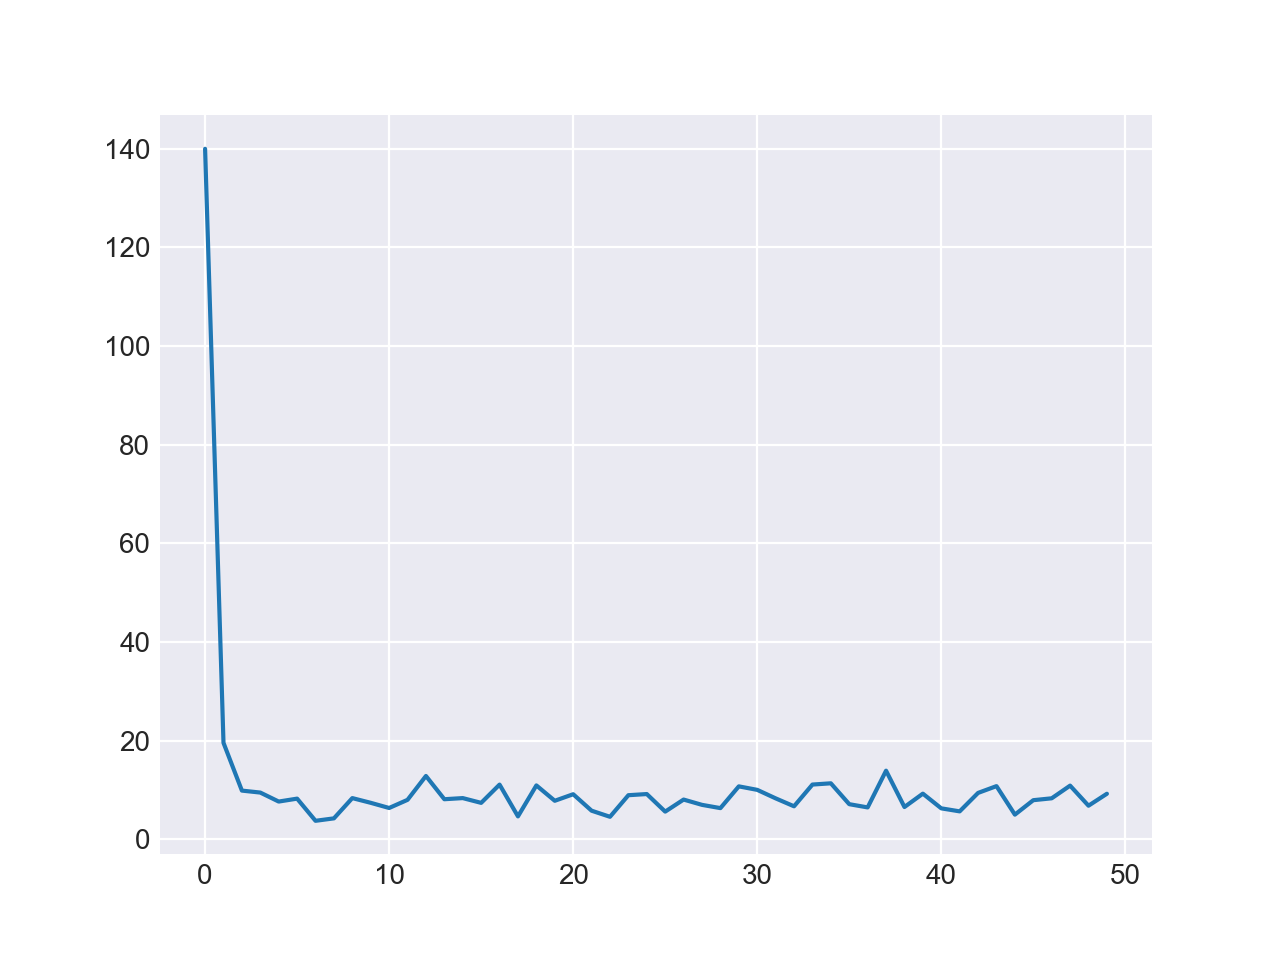

0.9139075552674842

In [60]:
n_samples = 5000
cov1 = np.identity((50))
t = create_t_0(50,5)
sigma = 0.1
Y1,X1 = data1(n_samples , t , sigma)

n_heavy_tail = 10
Y2,X2 = data3(n_heavy_tail,t)

n_outliers1 = 20
Y3,X3 = data2(n_outliers1, 50, type_outliers = 1)

n_outliers2 = 4
Y4,X4 = data2(n_outliers2, 50, type_outliers = 2)

Y5,X5 = data_merge(Y1,X1,Y2,X2)
Y6,X6 = data_merge(Y5,X5,Y3,X3)

Y,X = data_merge(Y6,X6,Y4,X4)

reg = MOM_ElasticNet(rho = 1, Lambda = 0.01, K = 15, random_state = True, max_iter = 50, tol = 10**-7)
reg.fit(X,Y)

plt.plot(np.arange(reg.Loss.shape[0]),reg.Loss)
plt.show()

reg.score(X1,Y1)

<IPython.core.display.Javascript object>


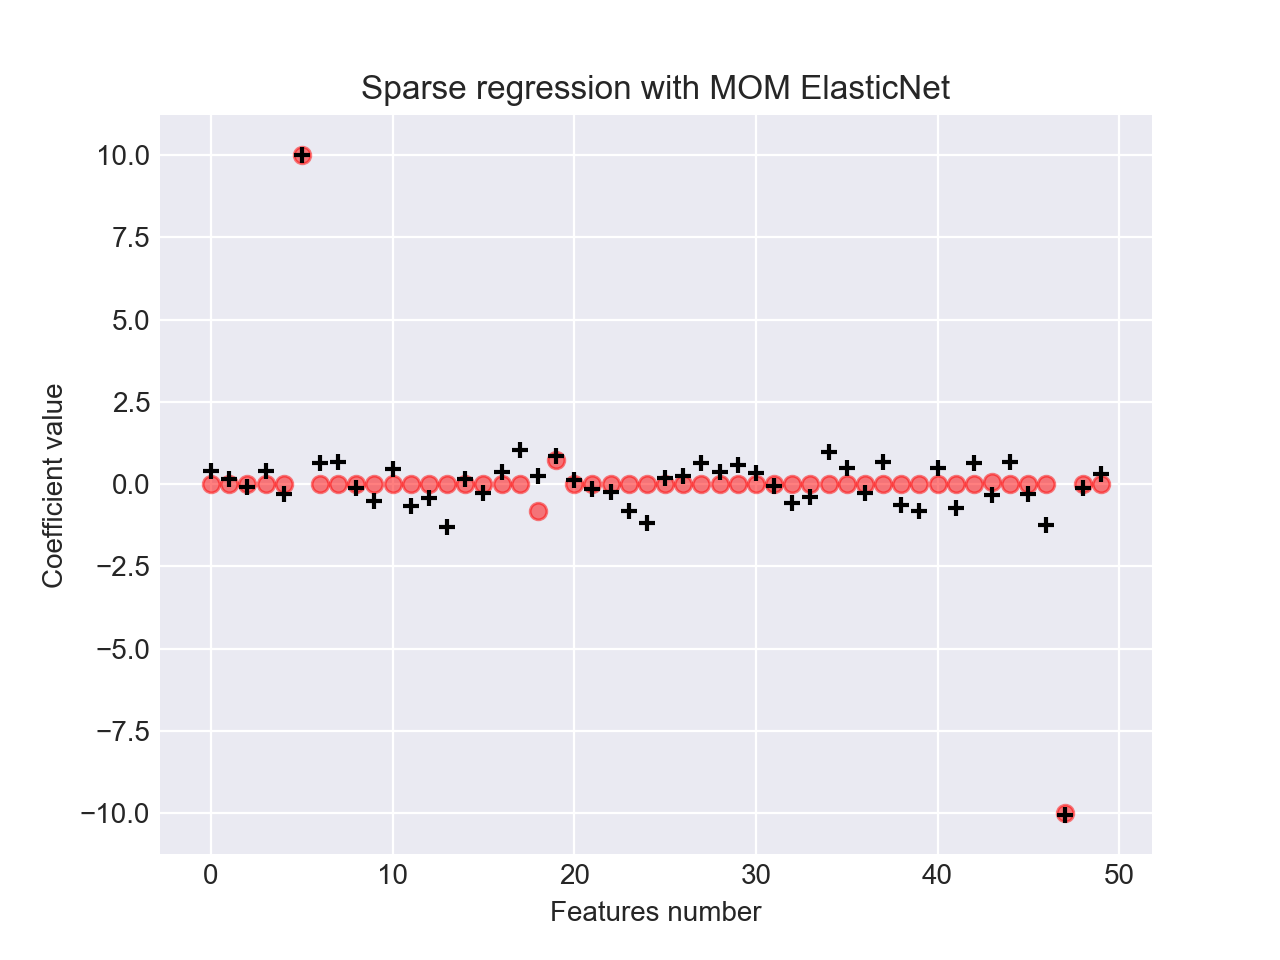

Text(0.5, 1.0, 'Sparse regression with MOM ElasticNet')

In [61]:
plt.scatter(np.arange(50) , t , color = 'red' , alpha = 0.5 , label = "t_0")
plt.scatter(np.arange(50) , reg.w , color = "black" , marker = "+" , label = "Estimation of t_0")
plt.xlabel("Features number")
plt.ylabel("Coefficient value")
plt.title('Sparse regression with MOM ElasticNet')